In [161]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [202]:
TIME_START = 1651363200000
TIME_END = 1681363200000

In [230]:
payload={}
headers={}

symbol= 'AAVEUSDT'

url = f'https://api.binance.com/api/v1/klines?symbol={symbol}&interval=5m&startTime={TIME_START}&endTime={TIME_END}&limit=1000'
print(url)
response = requests.request("GET", url, headers=headers, data=payload)

 
pd.DataFrame.from_records(response.json()).to_csv(f'KLINES_{symbol}.csv',index = 0, sep =';')

https://api.binance.com/api/v1/klines?symbol=AAVEUSDT&interval=5m&startTime=1651363200000&endTime=1681363200000&limit=1000


In [231]:
data_aaveusdt = pd.read_csv(f'KLINES_{symbol}.csv', header=0, sep=';')

In [257]:
data_aaveusdt = data_aaveusdt.rename(columns={'0':'open_time', '1':'open_price', '2':'high_price', '3':'low_price', '4':'close_price', '5': 'volume', '6': 'close_time', '7': 'quote_asset_volume', '8': 'number_of_trades', '9': 'taker_buy_base_asset_volume','10': 'taker_buy_quote_asset_volume', '11': 'ignore'})

In [258]:
data_aaveusdt

,open_time,open_price,high_price,low_price,close_price,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,ignore
0,1651363200000,142.3,143.2,142.0,143.2,2924.595,1651363499999,417324.1436,848,1760.140,251110.9920,0
1,1651363500000,143.3,143.3,142.9,143.1,1074.764,1651363799999,153790.6098,438,485.374,69463.9467,0
2,1651363800000,143.1,143.2,142.2,142.3,1007.979,1651364099999,143685.7155,476,576.632,82188.0801,0
3,1651364100000,142.2,142.4,141.8,141.9,1025.196,1651364399999,145722.1589,297,340.378,48405.7433,0
4,1651364400000,141.8,141.9,141.1,141.4,1136.703,1651364699999,160789.6151,431,834.693,118069.8736,0
...,...,...,...,...,...,...,...,...,...,...,...,...
995,1651661700000,150.0,150.1,149.7,149.8,249.119,1651661999999,37345.4693,143,152.645,22888.4636,0
996,1651662000000,149.9,150.2,149.8,149.9,385.579,1651662299999,57846.9598,139,124.139,18632.9194,0
997,1651662300000,149.9,149.9,149.1,149.4,767.245,1651662599999,114583.3904,250,313.129,46745.3593,0
998,1651662600000,149.4,149.4,148.4,148.8,1713.097,1651662899999,254800.0789,745,462.110,68716.8487,0


In [263]:
alpha_value = [i/10 for i in range(11)]

In [236]:
def exponential_smoothing(data, alpha):
    forecast_value = [data[0]]
    for i in range(1, len(data)):
        forecast = alpha * data[i] + (1 - alpha) * data[i - 1]
        forecast_value.append(forecast)
        
    return forecast_value

def choose_coefficient(alpha_value, data):
    best_alpha = None
    best_rmse = float(np.inf)
    for alpha in alpha_value:
        forecast_values = exponential_smoothing(data, alpha)
        
        differences = np.subtract(forecast_values, data)
        
        squared_errors = np.square(differences)
        
        mse = np.mean(squared_errors)
        
        rmse = np.sqrt(mse)
        
        if best_rmse > rmse:
            best_rmse = rmse
            best_alpha = alpha
    
    return best_alpha
        
    

In [237]:
best_alpha = choose_coefficient(alpha_value, data_aaveusdt.open_price)
print("Best alpha: %f" % best_alpha)

Best alpha: 1.000000


Так, як найкраща a = 1, то виберемо значення m, у формулу a = 2/(m+1), виберемо m = 3, тоді a = 0.5

In [238]:
forecast = exponential_smoothing(data_aaveusdt.open_price, 0.5)

In [239]:
def rmse(forecast, data):
    
    differences = np.subtract(forecast, data)
    
    squared_errors = np.square(differences)
    
    mse = np.mean(squared_errors)
    
    rmse = np.sqrt(mse)
    
    return rmse

def mape(forecast, data):
    percentage_errors = np.abs(np.divide(np.subtract(forecast, data), data)) * 100
    
    mape = np.mean(percentage_errors)
    
    return mape

def tp(forecast, data):
    
    tp = sum([1 for i in range(1, len(forecast)) if forecast[i] >= forecast[i - 1] and data[i] >= data[i - 1]])
    
    return tp + 1 #+1 тому, що перше значення в forecast буде таким же, як в data

def fp(forecast, data):
              
    fp = sum([1 for i in range(1, len(forecast)) if forecast[i] > forecast[i - 1] and data[i] < data[i - 1]])
    
    return fp
    
def tn(forecast, data):
              
    tn = sum([1 for i in range(1, len(forecast)) if forecast[i] <= forecast[i - 1] and data[i] <= data[i - 1]])
    
    return tn 
    
def fn(forecast, data):
              
    fn = sum([1 for i in range(1, len(forecast)) if forecast[i] < forecast[i - 1] and data[i] > data[i - 1]])
              
    return fn 

def misc(forecast, data):
    
    misc = 1 - (tp(forecast, data) + tn(forecast, data))/(tp(forecast, data) + tn(forecast, data) + fp(forecast, data) +fn(forecast, data))
    
    return misc
    

In [283]:
print(f"RMSE = {rmse(forecast, data_aaveusdt.open_price)}")
print(f"MAPE = {mape(forecast, data_aaveusdt.open_price)}")
print(f"TP = {tp(forecast, data_aaveusdt.open_price)}")
print(f"FP = {fp(forecast, data_aaveusdt.open_price)}")
print(f"TN = {tn(forecast, data_aaveusdt.open_price)}")
print(f"FN = {fn(forecast, data_aaveusdt.open_price)}")
print(f"MISC = {misc(forecast, data_aaveusdt.open_price)}")

RMSE = 0.2320937310657039
MAPE = 0.11856656281776781
TP = 387
FP = 87
TN = 442
FN = 91
MISC = 0.1767626613704072


In [281]:
x_arr = [i for i in range(801, 1001)]

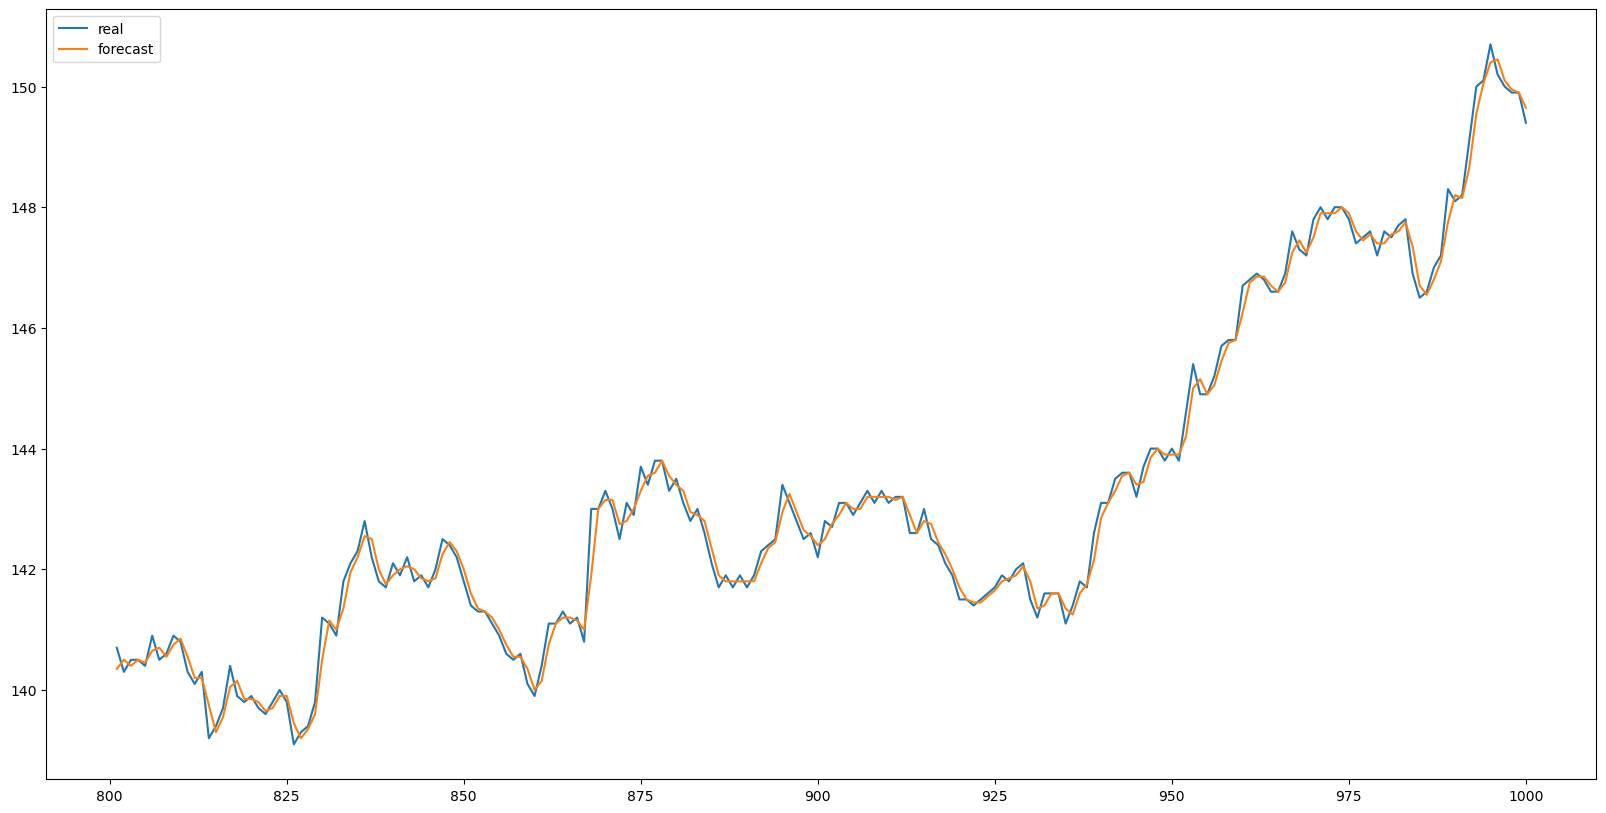

In [282]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 10)
ax.plot(x_arr, data_aaveusdt.open_price[799:999], label="real")
ax.plot(x_arr, forecast[799:999], label="forecast")
ax.legend(loc='upper left')
plt.show()
